In [6]:
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import scipy.stats

In [17]:
ff = pd.read_pickle("/glade/work/hpzhang/LCC_pred/data/data_monthly.pkl").dropna()
df = ff.drop(columns=['lat', 'lon', 'lsm', 'T1000', 'T700', 'EIS', 'ECTEI','ELF','SST', 'AOD'])
df = df[df.index.year.isin(np.arange(2003,2019))]

#X_test_scaled = np.load("/glade/work/hpzhang/LCC_pred/data/X_test_scaled.npy")

pred_XGB    = np.load('/glade/work/hpzhang/LCC_pred/data/XGB/y_pred_XGB.npy')
shap_values = np.load('/glade/work/hpzhang/LCC_pred/data/XGB/shap_values.npy')
shap_data   = np.load('/glade/work/hpzhang/LCC_pred/data/XGB/shap_data.npy')

In [9]:
data = df
index_train = data.index.year.isin(np.arange(2003,2015))
index_test  = data.index.year.isin(np.arange(2015,2019))
data_train = data[index_train]
data_test  = data[index_test]

X_train, y_train = data_train.iloc[:,1:], data_train.iloc[:,0]
X_test, y_test   = data_test.iloc[:,1:], data_test.iloc[:,0]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [10]:
lat = ff.lat[ff.index.year.isin(np.arange(2015,2019))]
lon = ff.lon[ff.index.year.isin(np.arange(2015,2019))]

OCN_index = (lat>=-60)&(lat<=60)
SO_index  = (lat>=-60)&(lat<-50)
SEP_index = ((lat>=-20)&(lat<-10)) & ((lon>=270)&(lon<280))
SEA_index = ((lat>=-20)&(lat<-10)) & ((lon>=0)&(lon<10))
SEI_index = ((lat>=-35)&(lat<-25)) & ((lon>=95)&(lon<105))
NEP_index = ((lat>=20)&(lat<30))   & ((lon>=230)&(lon<240))
NEA_index = (lat>=15)&(lat<25)     & ((lon>=325)&(lon<335))
NA_index  = (lat>=50)&(lat<60)     & ((lon>=315)&(lon<325))
NP_index  = (lat>=40)&(lat<50)     & ((lon>=170)&(lon<180))

regs = [NA_index, NP_index, NEP_index, NEA_index, SEP_index, SEA_index, SEI_index, SO_index]
regs_names = ['NA', 'NP', 'NEP', 'NEA', 'SEP', 'SEA', 'SEI', 'SO']

In [67]:
import pickle
import shap

### load model ###
file_name = "/glade/work/hpzhang/LCC_pred/data/xgb_reg.pkl"
xgb_model = pickle.load(open(file_name, "rb"))
lab = df.columns.drop('LCF')

def get_shapvalues(regs):
    tmp1 = pd.DataFrame(X_test_scaled, columns=lab)
    X_sampled = tmp1[regs.values].sample(1000, random_state=10)
    
    tmp2 = pd.DataFrame(X_test.values, columns=lab)
    feature_org = tmp2[regs.values].sample(1000, random_state=10)

    explainer = shap.Explainer(xgb_model)
    shap_values = explainer(X_sampled)
    
    return shap_values, feature_org


In [68]:
shap_values = []
feature_values = []
for i in regs:
    tmp1,tmp2 = get_shapvalues(i)
    shap_values.append(tmp1)
    feature_values.append(tmp2)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


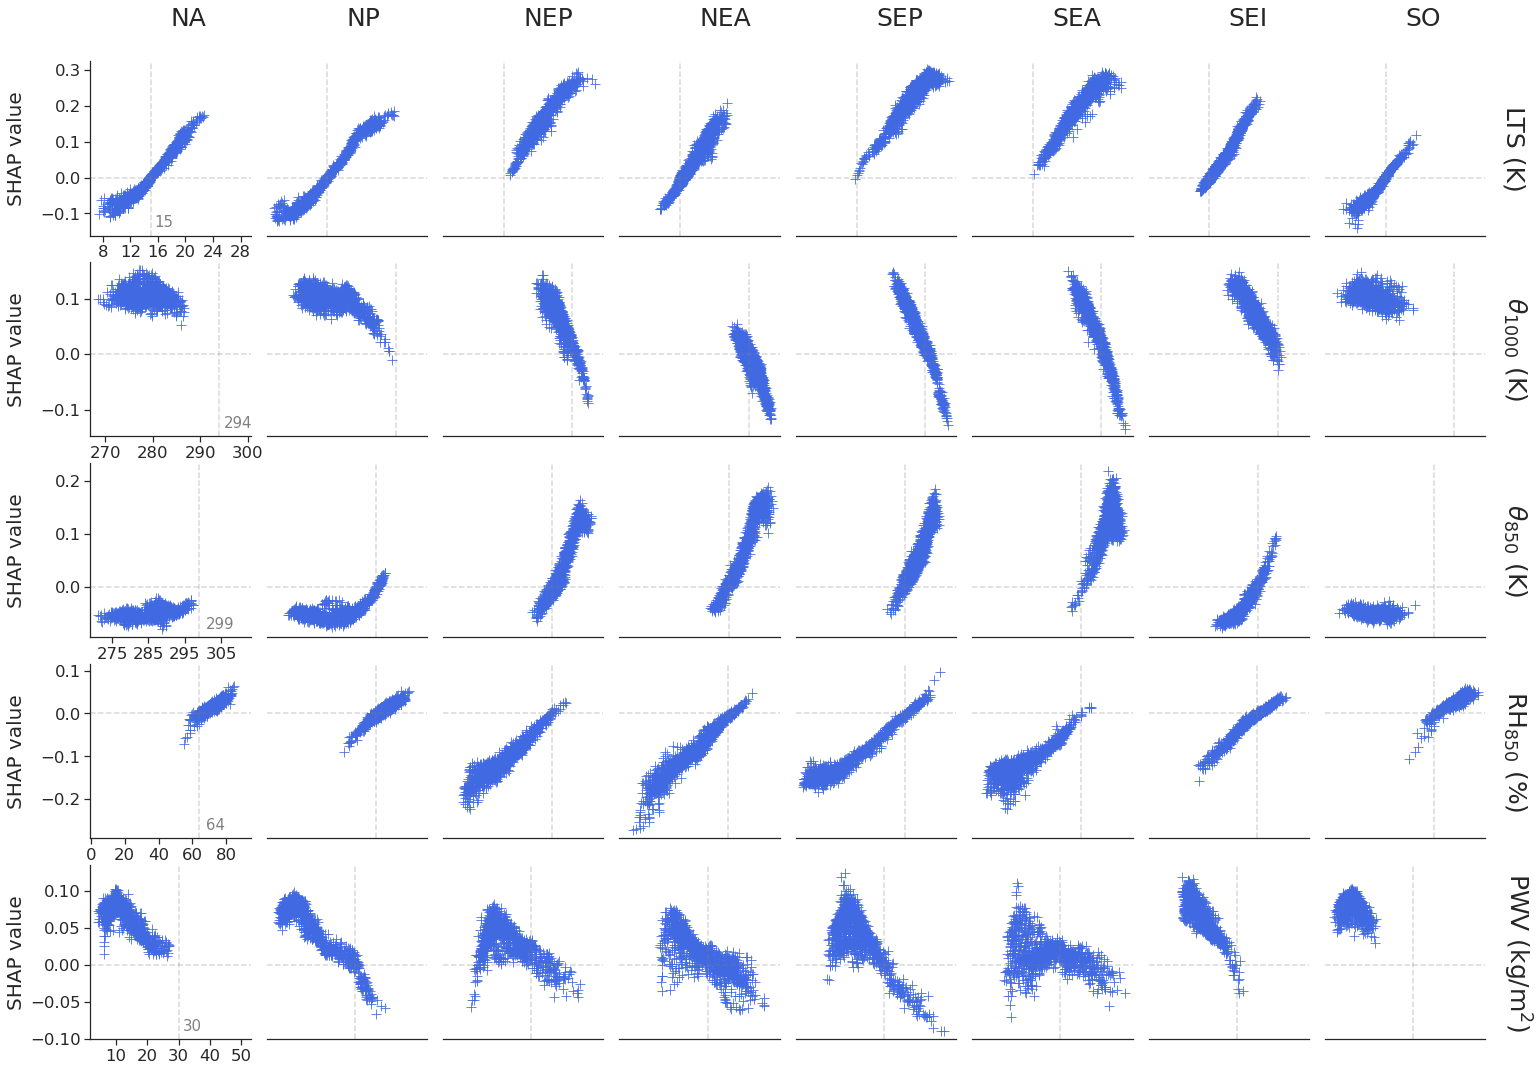

In [119]:
import matplotlib.ticker as ticker

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 1.5)

fig, axes = plt.subplots(5, 8, figsize=[25, 18], sharex='row', sharey='row')

def simpleaxis(ax):
    ax.spines['left'].set_visible(False)
    ax.tick_params(left=False)
    
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(bottom=False)
    

vars = ['LTS', 'TH1000', 'TH850', 'RH850', 'PWV']
labels = ['LTS (K)', '$\\theta_{1000}$ (K)', '$\\theta_{850}$ (K)', 'RH$_{850}$ (%)', 'PWV (kg/m$^2$)']
for i, ax in enumerate(axes.flat):
      
      ic = i%8
      ir = i//8
      g = sns.scatterplot(x=feature_values[ic][vars[ir]].values,
                          y=shap_values[ic][:,vars[ir]].values.flatten(),
                          s=100, color="royalblue", marker="+",
                          ax=ax)
      ax.axhline(y = 0, color = 'grey', linestyle = 'dashed', alpha=0.3)
    
      if ic != 0:
           simpleaxis(ax)
    
      if (ic == 0):
            ax.set_ylabel('SHAP value', fontsize=20)
            ax.get_yaxis().set_label_coords(-0.4, 0.5)
            
            if ir == 0:
                ax.set_xticks(np.arange(8,28.1,4))
                ax.annotate('15', xy=(0.4, 0.05), xycoords='axes fraction', fontsize=15, color='grey')
            if ir == 1:
                ax.set_xticks(np.arange(270,300.1,10))
                ax.annotate('294', xy=(0.83, 0.05), xycoords='axes fraction', fontsize=15, color='grey')
            if ir == 2:
                ax.set_xticks(np.arange(275,310.1,10))
                ax.annotate('299', xy=(0.72, 0.05), xycoords='axes fraction', fontsize=15, color='grey')
            if ir == 3:
                ax.set_xticks(np.arange(0,100.1,20))
                ax.annotate('64', xy=(0.72, 0.05), xycoords='axes fraction', fontsize=15, color='grey')
            if ir == 4:
                ax.set_xticks(np.arange(0,50.1,10))
                ax.annotate('30', xy=(0.58, 0.05), xycoords='axes fraction', fontsize=15, color='grey')
            
      if (ic == 7):
            ax.annotate(labels[ir], xy=(1.1, 0.5), xycoords='axes fraction', fontsize=25, rotation=270, va='center')

      if (ir == 0):
            ax.annotate(regs_names[ic], xy=(0.5, 1.2), xycoords='axes fraction', fontsize=25)
            ax.axvline(x = 15, color = 'grey', linestyle = 'dashed', alpha=0.3)
      if (ir == 1):
            ax.axvline(x = 294, color = 'grey', linestyle = 'dashed', alpha=0.3)
      if (ir == 2):
            ax.axvline(x = 299, color = 'grey', linestyle = 'dashed', alpha=0.3)   
      if (ir == 3):
            ax.axvline(x = 64, color = 'grey', linestyle = 'dashed', alpha=0.3)
      if (ir == 4):
            ax.axvline(x = 30, color = 'grey', linestyle = 'dashed', alpha=0.3) 

plt.subplots_adjust(hspace=0.15, wspace=0.1)
plt.show()

<Figure size 720x432 with 0 Axes>

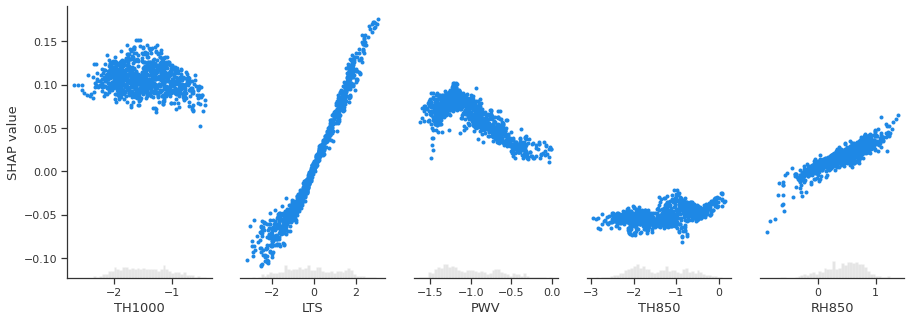

In [14]:
ax = plt.figure(figsize=(10, 6))
shap.plots.scatter(shap_values[0][:,['TH1000', 'LTS', 'PWV', 'TH850', 'RH850']], color=shap_values, ax=ax)